In [1]:
import numpy as np
import scipy
from scipy import signal, optimize
import pandas as pd

import warnings

from matplotlib import pyplot as plt
import seaborn as sns

import theory
import utility
from utility import A2db, P2db, db2A, db2P
from mapping import qam_sym2iq_map, qam_mapping, qam_demapping, qam_order2bits, qam_simmetry_bits, qam_vh_bits, gray_code
from pcs import ccdm_encode, ccdm_decode, ccdm_make_cfg_min_bits, ccdm_make_cfg_probability, Comb, qam_optimal_p0

<IPython.core.display.Javascript object>


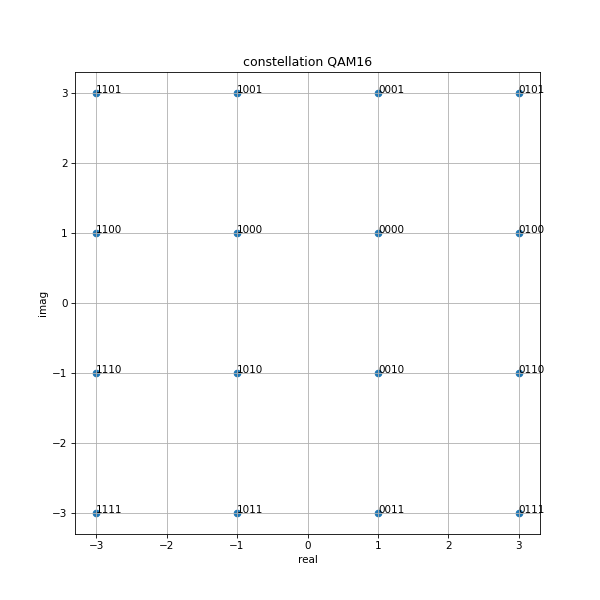

Text(0.5, 1.0, 'constellation QAM16')

In [2]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))

constel_M = 16
constel_Mbits = qam_order2bits(constel_M)
constel = qam_sym2iq_map(constel_M)

plt.scatter(constel.real, constel.imag, s=40)
plt.grid(True)

plot_zero_bits_cnt = False
for i in range(constel_M):
    if not plot_zero_bits_cnt:
        plt.text(constel[i].real, constel[i].imag, ('{:0'+str(constel_Mbits)+'b}').format(i))
    else:
        v_bit, h_bit = qam_vh_bits(constel_M)
        plt.text(constel[i].real, constel[i].imag, 
                 ('{}').format((('{:0'+str(constel_Mbits)+'b}').format(i)[1:constel_Mbits//2] + 
                                ('{:0'+str(constel_Mbits)+'b}').format(i)[constel_Mbits//2+1:constel_Mbits]).count('0')))
    

plt.xlabel('real')
plt.ylabel('imag')
plt.title('constellation QAM{}'.format(constel_M))

In [3]:
# Main parameters
N_sym = int(4e5)  # Length of signal

cfgs = [
    pd.Series({'N_sym': N_sym, 'M': 4, 'shaping': 'none'}),
    pd.Series({'N_sym': N_sym, 'M': 16, 'shaping': 'none'}),
    pd.Series({'N_sym': N_sym, 'M': 64, 'shaping': 'none'}),
    
    pd.Series({'N_sym': N_sym, 'M': 16, 'shaping': 'ideal', 'C': 3.5}),
    #pd.Series({'N_sym': N_sym, 'M': 16, 'shaping': 'ccdm', 
    #            'ccdm_cfg': ccdm_make_cfg_min_bits(3*8, 4*8)}),
    pd.Series({'N_sym': N_sym, 'M': 16, 'shaping': 'ccdm', 
               'ccdm_cfg': ccdm_make_cfg_probability(3*8, 4*8, qam_optimal_p0(3.5)[0])}),
]

for cfg in cfgs:
    cfg['Mbits'] = qam_order2bits(cfg.M)
    
    cfg['tx'] = pd.Series(dtype=object)
    
    if cfg.shaping == 'none':
        cfg.tx['bit_stream_mapping'] = np.random.choice([0, 1], (cfg.Mbits*cfg.N_sym, ))
    
    elif cfg.shaping == 'ideal':
        v_bit, h_bit = qam_vh_bits(cfg.M)
        p0, p1 = qam_optimal_p0(cfg.C)
        
        cfg.tx['vh_bits'] = np.random.choice([0, 1], (2*cfg.N_sym, ))
        cfg.tx['amp_bits'] = (np.random.rand((cfg.Mbits-2)*cfg.N_sym) > p0).astype(int)
        
        cfg.tx['v_bits_ind'] = np.arange(v_bit, cfg.N_sym * cfg.Mbits, cfg.Mbits)
        cfg.tx['h_bits_ind'] = np.arange(h_bit, cfg.N_sym * cfg.Mbits, cfg.Mbits)
        cfg.tx['amp_bits_ind'] = np.setdiff1d(
            np.arange(cfg.N_sym*cfg.Mbits), 
            np.hstack([cfg.tx.v_bits_ind, cfg.tx.h_bits_ind]), 
            assume_unique=True
        )

        cfg.tx['bit_stream_mapping'] = np.zeros(cfg.N_sym * cfg.Mbits, dtype=int)
        cfg.tx.bit_stream_mapping[cfg.tx.v_bits_ind] = cfg.tx.vh_bits[:cfg.tx.vh_bits.size//2]
        cfg.tx.bit_stream_mapping[cfg.tx.h_bits_ind] = cfg.tx.vh_bits[cfg.tx.vh_bits.size//2:]

        cfg.tx.bit_stream_mapping[cfg.tx.amp_bits_ind] = cfg.tx.amp_bits
    
    elif cfg.shaping == 'ccdm':
        v_bit, h_bit = qam_vh_bits(cfg.M)
        cfg.N_sym = cfg.N_sym + (cfg.ccdm_cfg.c_sz - cfg.N_sym % cfg.ccdm_cfg.c_sz)

        cfg.tx['vh_bits'] = np.random.choice([0, 1], (2*cfg.N_sym, ))

        cfg.tx['amp_bits_nc'] = np.random.choice([0, 1], (cfg.N_sym*(cfg.Mbits-2)*cfg.ccdm_cfg.d_sz//cfg.ccdm_cfg.c_sz, ))
        cfg.tx['amp_bits'] = ccdm_encode(
            cfg.tx.amp_bits_nc, 
            cfg.ccdm_cfg.one_bits, 
            cfg.ccdm_cfg.d_sz, 
            cfg.ccdm_cfg.c_sz
        )

        cfg.tx['v_bits_ind'] = np.arange(v_bit, cfg.N_sym * cfg.Mbits, cfg.Mbits)
        cfg.tx['h_bits_ind'] = np.arange(h_bit, cfg.N_sym * cfg.Mbits, cfg.Mbits)
        cfg.tx['amp_bits_ind'] = np.setdiff1d(
            np.arange(cfg.N_sym*cfg.Mbits), 
            np.hstack([cfg.tx.v_bits_ind, cfg.tx.h_bits_ind]), 
            assume_unique=True
        )

        cfg.tx['bit_stream_mapping'] = np.zeros(cfg.N_sym * cfg.Mbits, dtype=int)
        cfg.tx.bit_stream_mapping[cfg.tx.v_bits_ind] = cfg.tx.vh_bits[:cfg.tx.vh_bits.size//2]
        cfg.tx.bit_stream_mapping[cfg.tx.h_bits_ind] = cfg.tx.vh_bits[cfg.tx.vh_bits.size//2:]

        cfg.tx.bit_stream_mapping[cfg.tx.amp_bits_ind] = cfg.tx.amp_bits
    
    else:
        assert False, 'bad shaping value ({})'.format(cfg.shaping)
        
    cfg.tx['X'] = qam_mapping(cfg.tx.bit_stream_mapping, cfg.M)



C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/2721354774.py:13: DeprecationWarning: one_bits_min = 9 > one_bits_prob = 7.0, falling to one_bits_min, p0=0.72 (desired p0=0.79)
  'ccdm_cfg': ccdm_make_cfg_probability(3*8, 4*8, qam_optimal_p0(3.5)[0])}),


# Plot BER/SNR (OSNR)

In [4]:
Fs = 10e9  # Frequency band in Hz

snr_db_range = np.linspace(0, 20, 20)
osnr_db_range = utility.snr2osnr_db(snr_db_range, Fs)
#ber_theory = theory.theory_ber(snr_db_range, M)



for cfg in cfgs:
    cfg['rx'] = pd.Series({
        'ber_sim': np.zeros(snr_db_range.size),
    })
    if cfg.shaping in ['ideal', 'ccdm']:
        cfg.rx['ber_vh'] = np.zeros(snr_db_range.size)
        cfg.rx['ber_amp'] = np.zeros(snr_db_range.size)
        if cfg.shaping == 'ccdm':
            cfg.rx['ber_ccdm'] = np.zeros(snr_db_range.size)
    
    for i in range(len(snr_db_range)):
        snr_db = snr_db_range[i]
        # Generating noise
        #noise = db2A(-snr_db) * (np.random.randn(X.size) + 1j * np.random.randn(X.size)) / np.sqrt(2) * np.sqrt(np.var(constel))
        noise = db2A(-snr_db)/ np.sqrt(2) * np.sqrt(np.var(cfg.tx.X)) * \
                (np.random.randn(cfg.tx.X.size) + 
                1j * np.random.randn(cfg.tx.X.size))
        
        X_noisy = cfg.tx.X + noise

        # Hard slicing
        bit_stream_demapping = qam_demapping(X_noisy, cfg.M)
        
        # BER calculation
        cfg.rx.ber_sim[i] = np.mean(np.abs(bit_stream_demapping - cfg.tx.bit_stream_mapping))
            
        if cfg.shaping in ['ideal', 'ccdm']:
            v_bits = bit_stream_demapping[cfg.tx.v_bits_ind]
            h_bits = bit_stream_demapping[cfg.tx.h_bits_ind]
            vh_bits = np.hstack([v_bits, h_bits])
            
            amp_bits = bit_stream_demapping[cfg.tx.amp_bits_ind]
            cfg.rx.ber_vh[i] = np.mean(np.abs(cfg.tx.vh_bits - vh_bits))
            cfg.rx.ber_amp[i] = np.mean(np.abs(cfg.tx.amp_bits - amp_bits))
            
            if cfg.shaping=='ccdm':
                ccdm_amp_bits_nc = ccdm_decode(amp_bits, cfg.ccdm_cfg.one_bits, cfg.ccdm_cfg.d_sz, cfg.ccdm_cfg.c_sz)
                cfg.rx.ber_ccdm[i] = np.mean(np.abs(cfg.tx.amp_bits_nc - ccdm_amp_bits_nc))

            


<IPython.core.display.Javascript object>


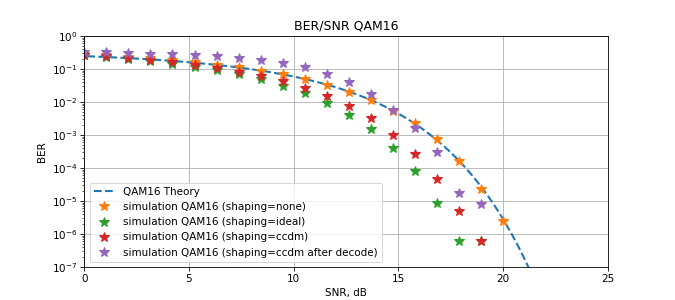

Text(0.5, 1.0, 'BER/SNR QAM16')

In [5]:
%matplotlib notebook

# Plotting BER vs SNR curve
fig = plt.figure(figsize=(9, 4))

ber_snr_M_set = [16]

for theory_M in ber_snr_M_set:   
    theory_snr_db_range = np.linspace(-10, 25, 100)
    plt.semilogy(theory_snr_db_range, theory.theory_ber(theory_snr_db_range, theory_M), 
                 '--', linewidth=2, 
                 label="QAM{} Theory".format(theory_M))

for cfg in cfgs:
    
    if not (cfg.M in ber_snr_M_set):
        continue
    
    plt.semilogy(
        snr_db_range, 
        cfg.rx.ber_sim, 
        '*', markersize=10, 
        label='simulation QAM{} (shaping={})'.format(cfg.M, cfg.shaping)
    )
    
    if cfg.shaping == 'ccdm':
        plt.semilogy(
            snr_db_range, 
            (cfg.rx.ber_vh * cfg.tx.vh_bits.size + cfg.rx.ber_ccdm*cfg.tx.amp_bits_nc.size)/(cfg.tx.vh_bits.size+cfg.tx.amp_bits_nc.size), 
            '*', markersize=10, 
            label='simulation QAM{} (shaping={} after decode)'.format(cfg.M, cfg.shaping)
        )
    
plt.xlim((0, 25))
plt.ylim((1e-7, 1))
plt.xlabel('SNR, dB')
plt.ylabel('BER')
plt.legend()
plt.grid(True)
plt.title('BER/SNR QAM{}'.format(theory_M))

<IPython.core.display.Javascript object>


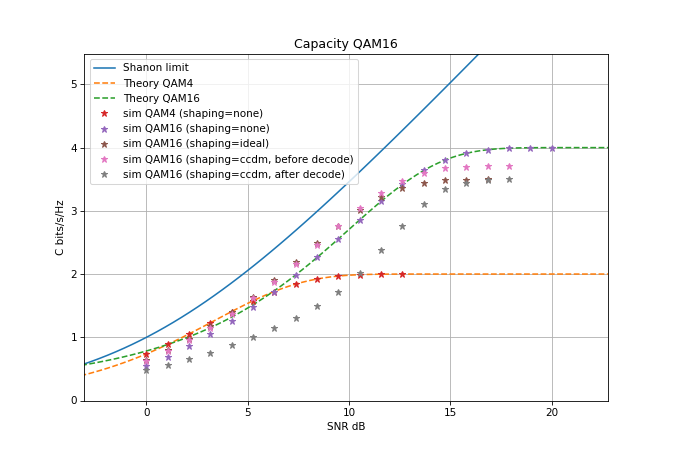

C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: divide by zero encountered in log2
  res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: invalid value encountered in multiply
  res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: divide by zero encountered in log2
  res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: invalid value encountered in multiply
  res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: divide by zero encountered in log2
  res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
C:\Users\sasha\AppData\Local\Temp/ipykernel_8176/955615163.py:14: RuntimeWarning: invalid value encountered i

In [6]:
%matplotlib notebook

def ber2cap(ber, bits=1, p01=np.array([0.5, 0.5])):
    res = 0.
    
    p_x = p01
    p_y = [p_x[0]*(1-ber) + p_x[1]*ber, 
           p_x[0]*ber + p_x[1]*(1-ber)]
    p_xy = [[ p01[0]*(1-ber), p01[0]*ber      ], 
            [ p01[1]*ber,     p01[1]*(1-ber)] ]
    
    for x in [0, 1]:
        for y in [0, 1]:
            res += p_xy[x][y] * np.log2( p_xy[x][y]/(p_x[x]*p_y[y]) )
    
    return bits*res


# plot Capacity
fig = plt.figure(figsize=(9, 6))

cap_M_set = [4, 16]
cap_shaping_set = ['none', 'ideal', 'ccdm']


plt.plot(np.linspace(-10, 30, 100), np.log2(1+db2P(np.linspace(-10, 30, 100))), label='Shanon limit')

for theory_M in cap_M_set:
    theory_snr_db_range = np.linspace(-10, 25, 100)
    plt.plot(theory_snr_db_range, 
             ber2cap(theory.theory_ber(theory_snr_db_range, theory_M), bits=qam_order2bits(theory_M)), 
             '--', label='Theory QAM{}'.format(theory_M))

for cfg in cfgs:
    if (not (cfg.M in cap_M_set)) or (not (cfg.shaping in cap_shaping_set)):
        continue
    
    if cfg.shaping == 'none':
        plt.plot(snr_db_range, 
                 ber2cap(cfg.rx.ber_sim, bits=cfg.Mbits), 
                 '*', 
                 label='sim QAM{} (shaping={})'.format(cfg.M, cfg.shaping))
        
    elif cfg.shaping == 'ideal':
        plt.plot(
            snr_db_range, 
            ber2cap(cfg.rx.ber_vh, bits=2) + \
            ber2cap(cfg.rx.ber_amp, bits=cfg.Mbits-2, p01=qam_optimal_p0(cfg.C)), 
            '*', 
            label='sim QAM{} (shaping={})'.format(cfg.M, cfg.shaping))
    
    elif cfg.shaping == 'ccdm': 
        plt.plot(
            snr_db_range, 
            ber2cap(cfg.rx.ber_vh, bits=2) + \
            ber2cap(cfg.rx.ber_amp, bits=cfg.Mbits-2, p01=[1 - cfg.ccdm_cfg.one_bits/cfg.ccdm_cfg.c_sz, 
                                                           cfg.ccdm_cfg.one_bits/cfg.ccdm_cfg.c_sz]), 
            '*', 
            label='sim QAM{} (shaping={}, before decode)'.format(cfg.M, cfg.shaping))
        
        plt.plot(
            snr_db_range, 
            ber2cap(cfg.rx.ber_vh, bits=2) + \
            ber2cap(cfg.rx.ber_ccdm, bits=(cfg.Mbits-2)*cfg.ccdm_cfg.d_sz/cfg.ccdm_cfg.c_sz, p01=[0.5, 0.5]),
            '*', 
            label='sim QAM{} (shaping={}, after decode)'.format(cfg.M, cfg.shaping))
        
        

plt.xlim(-10, 25)
plt.ylim(0, 6)
plt.grid(True)
plt.title("Capacity QAM{}".format(cfg.M))
plt.xlabel("SNR dB")
plt.ylabel("C bits/s/Hz")
plt.legend()

<IPython.core.display.Javascript object>


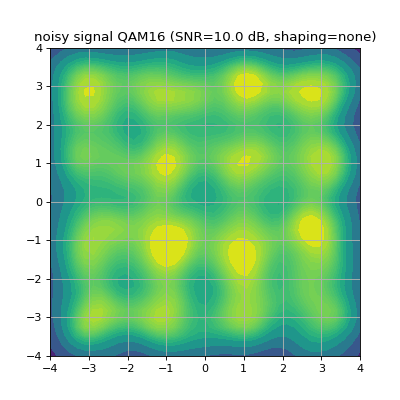

<IPython.core.display.Javascript object>


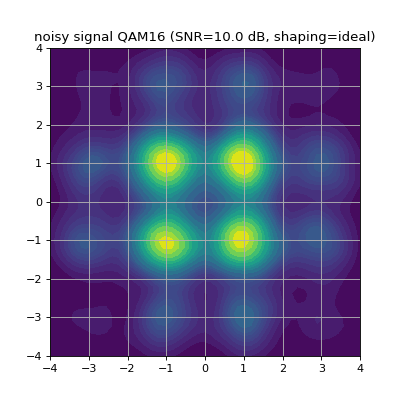

<IPython.core.display.Javascript object>


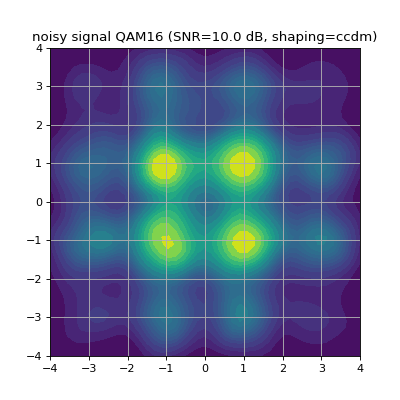

In [59]:
%matplotlib notebook

snr_db = 10
data_mx_sz = int(1e4)
for cfg in cfgs:
    if cfg.M != 16:
        continue
        
    sz_to_plt = min(data_mx_sz, cfg.tx.X.size)
    
    X = cfg.tx.X[:sz_to_plt]
    noise = db2A(-snr_db)/ np.sqrt(2) * np.sqrt(np.var(X)) * \
            (np.random.randn(X.size) + 
            1j * np.random.randn(X.size))

    X_noisy = X + noise
    
    fig = plt.figure(figsize=(5, 5))
    
    plt.grid(True)
    plt.title('noisy signal QAM{} (SNR={:.1f} dB, shaping={})'.format(cfg.M, snr_db, cfg.shaping))
    sns.kdeplot(
        x=X_noisy.real[:50000], y=X_noisy.imag[:50000],
        fill=True, thresh=0, levels=20, cmap="viridis", bw_adjust=0.7, gridsize=64
    )
    plt.xlim((-np.sqrt(cfg.M), np.sqrt(cfg.M)))
    plt.ylim((-np.sqrt(cfg.M), np.sqrt(cfg.M)))